In [1]:
import numpy as np
from FastCCM import CCM
from manifold_learning.utils import utils
from manifold_learning.data.data_loader import get_truncated_lorenz_rand
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from manifold_learning import imd_nd_smap
from sklearn.decomposition import PCA
import importlib
importlib.reload(imd_nd_smap)
importlib.reload(CCM)

<module 'FastCCM.CCM' from '/home/iaroslav/Documents/Python projects/FastCCM/src/FastCCM/CCM.py'>

In [2]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

In [3]:
def gaussian_kernel(x, y, sigma=1.0):
    return np.exp(-np.linalg.norm(x - y,axis=1)**2 / (2 * sigma**2))

In [480]:
X = get_truncated_lorenz_rand(800,n_steps=40000,)

X = StandardScaler().fit_transform(X)

In [481]:
def rotate_time_series(time_series, amplitude, frequency, phase):
    rotated_time_series = []
    
    for t, point in enumerate(time_series):
        # Sinusoidal function for the angle at each time step t
        theta = amplitude * np.sin(frequency * t + phase)
        
        # Rotation matrix around the Y-axis
        rotation_matrix = np.array([
            [1, 0, 0],
            [0, np.cos(theta), -np.sin(theta)],
            [0, np.sin(theta), np.cos(theta)]
        ])
        
        # Apply the rotation to the point (x, y, z)
        rotated_point = np.dot(rotation_matrix, point)
        rotated_time_series.append(rotated_point)
    
    return np.array(rotated_time_series)


X_ = rotate_time_series(X,1,0.02,1)

In [482]:
exp_kernel_grid = np.array(np.meshgrid(np.linspace(X[:,0].min(),X[:,0].max(),20), np.linspace(X[:,2].min(),X[:,2].max(),20))).reshape(2,-1).T

In [483]:

observables = np.array([gaussian_kernel(X_[:,[0,2]],e,sigma=1) for e in exp_kernel_grid]).T
#observables[observables < 0.1] = 0
#mixing_mat = np.random.normal(size=(observables.shape[1],100))
#observables = observables @ mixing_mat
#observables = StandardScaler().fit_transform(observables)


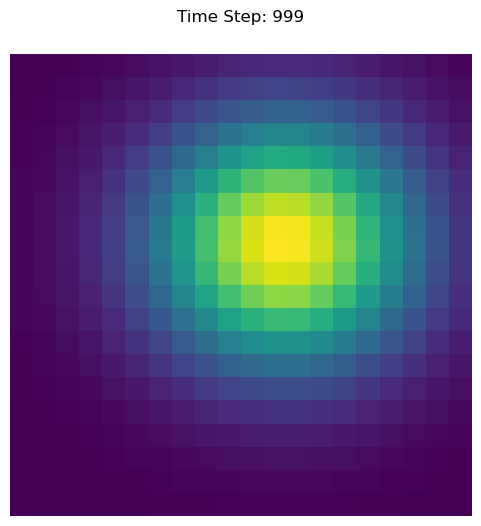

In [484]:

import matplotlib.animation as animation

def generate_time_series_video(time_series, video_filename='time_series_animation.mp4', fps=30, cmap='viridis', interval=50):
    """
    Generates a video from a 3D time series using matplotlib's matshow.

    Parameters:
    - time_series: 3D numpy array of shape (time_steps, width, height)
    - video_filename: Output video filename (default is 'time_series_animation.mp4')
    - fps: Frames per second for the video (default is 30)
    - cmap: Color map for the matshow visualization (default is 'viridis')
    - interval: Interval (in ms) between frames in the animation (default is 50 ms)
    """
    time_steps, width, height = time_series.shape

    # Create a figure and axis for the animation
    fig, ax = plt.subplots(figsize=(6, 6))

    # Function to update the frame in the animation
    def update_frame(t):
        ax.clear()  # Clear the axis to avoid overlapping
        ax.matshow(time_series[t], cmap=cmap)  # Display the frame with matshow
        ax.set_title(f'Time Step: {t}')
        ax.axis('off')  # Turn off axis

    # Create the animation
    ani = animation.FuncAnimation(fig, update_frame, frames=range(time_steps), interval=interval, repeat=False)

    # Save the animation as a video file (requires ffmpeg installed)
    ani.save(video_filename, writer='ffmpeg', fps=fps)

generate_time_series_video(observables.reshape(-1,20,20)[:1000])


In [485]:

observables = utils.get_td_embedding_np(observables,2,15).reshape(-1,2*observables.shape[1])

In [486]:
plt.figure(figsize=(8,6),dpi=100)
plt.plot(X_[0][:,0],X_[0][:,1],color="black",lw=0.5)
plt.scatter(*exp_kernel_grid.T,color="red",zorder=100)
plt.xlabel("x")
plt.ylabel("z")
plt.title("Lorenz attractor")
plt.legend()

IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

<Figure size 800x600 with 0 Axes>

In [12]:
plt.figure(figsize=(10,6),dpi=100)
plt.plot(X_[0][:,0],X_[0][:,1],color="black",lw=0.5)
plt.scatter(X_[0][:,0],X_[0][:,1],c=observables[:,26],zorder=100,cmap="magma")
plt.xlabel("x")
plt.ylabel("z")
plt.title("Lorenz attractor, receptive field of one kernel")
plt.colorbar()

IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

<Figure size 1000x600 with 0 Axes>

Text(0, 0.5, 'Observation')

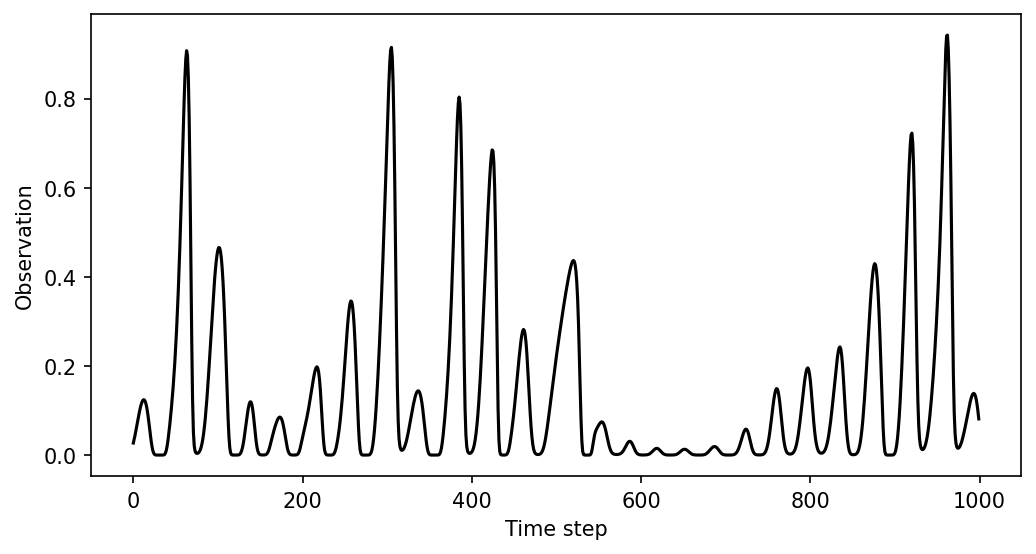

In [487]:
plt.figure(figsize=(8,4),dpi=150)
plt.plot(observables[:1000,26],color="black")
plt.xlabel("Time step")
plt.ylabel("Observation")

Text(0.5, 0, 'Time step')

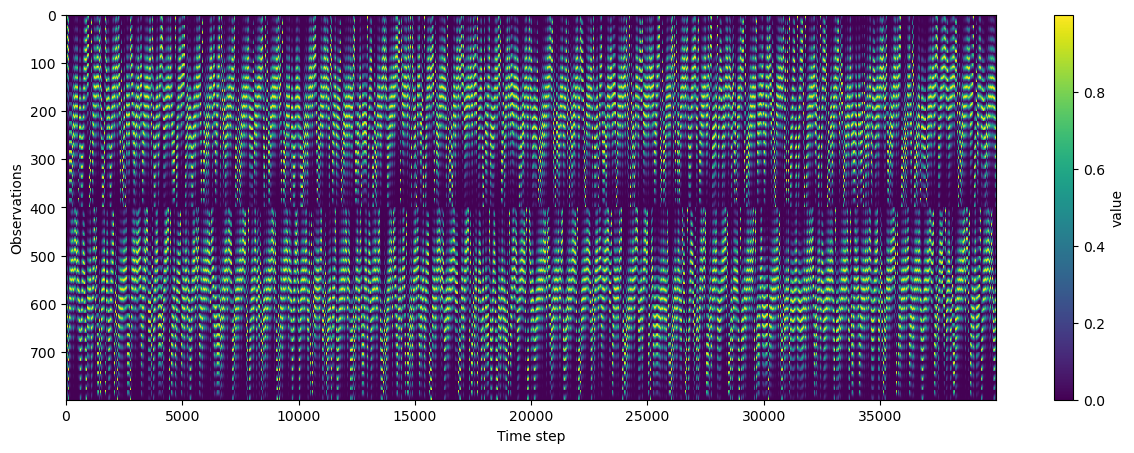

In [488]:
plt.figure(figsize=(15,5))
plt.imshow(observables.T,aspect="auto",interpolation="nearest")
plt.colorbar(label="value")
plt.ylabel("Observations")
plt.xlabel("Time step")

In [503]:
trainer = imd_nd_smap.IMD_nD_smap(observables.shape[1], embed_dim=10, n_components=2, subtract_corr=False, device="cuda")



In [504]:
trainer.fit(observables, sample_len=150, library_len=800, 
            exclusion_rad=30, theta=3, tp=30, 
            epochs=1000, num_batches=32,optimizer="Adagrad", learning_rate=0.01, tp_policy="range",loss_mask_size=None)
            


Epoch 1/1000, Loss: 0.9946
Epoch 2/1000, Loss: 0.9982
Epoch 3/1000, Loss: 0.9947
Epoch 4/1000, Loss: 0.9802
Epoch 5/1000, Loss: 0.9771
Epoch 6/1000, Loss: 0.9860
Epoch 7/1000, Loss: 0.9562
Epoch 8/1000, Loss: 0.9526
Epoch 9/1000, Loss: 0.9510
Epoch 10/1000, Loss: 0.9545
Epoch 11/1000, Loss: 0.9281
Epoch 12/1000, Loss: 0.9265
Epoch 13/1000, Loss: 0.9334
Epoch 14/1000, Loss: 0.9034
Epoch 15/1000, Loss: 0.9045
Epoch 16/1000, Loss: 0.8775
Epoch 17/1000, Loss: 0.8955
Epoch 18/1000, Loss: 0.8756
Epoch 19/1000, Loss: 0.8844
Epoch 20/1000, Loss: 0.8774
Epoch 21/1000, Loss: 0.8501
Epoch 22/1000, Loss: 0.8681
Epoch 23/1000, Loss: 0.8482
Epoch 24/1000, Loss: 0.8254
Epoch 25/1000, Loss: 0.8419
Epoch 26/1000, Loss: 0.8078
Epoch 27/1000, Loss: 0.8301
Epoch 28/1000, Loss: 0.7958
Epoch 29/1000, Loss: 0.7847
Epoch 30/1000, Loss: 0.7963
Epoch 31/1000, Loss: 0.8505
Epoch 32/1000, Loss: 0.7839
Epoch 33/1000, Loss: 0.8109
Epoch 34/1000, Loss: 0.7947
Epoch 35/1000, Loss: 0.7775
Epoch 36/1000, Loss: 0.8000
E

KeyboardInterrupt: 

Text(0, 0.5, 'Loss')

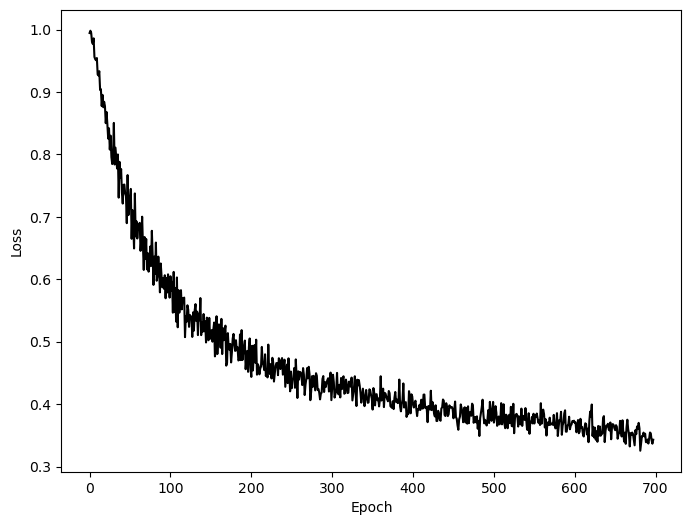

In [505]:
plt.figure(figsize=(8,6),dpi=100)
plt.plot(trainer.get_loss_history()[:],color="black")
plt.xlabel("Epoch")
plt.ylabel("Loss")


In [506]:

unmixed = trainer.predict(observables)

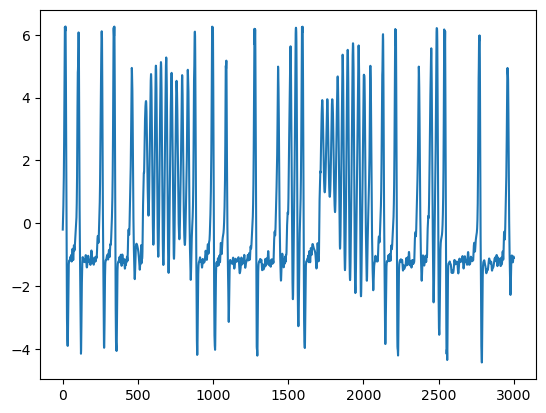

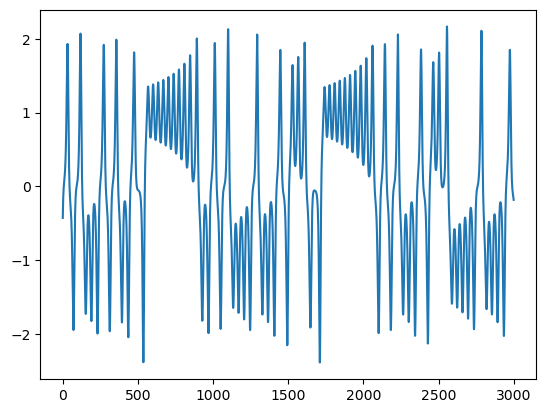

In [507]:

plt.plot(unmixed[:3000,0,0])
plt.show()
plt.plot(X[:3000,0])

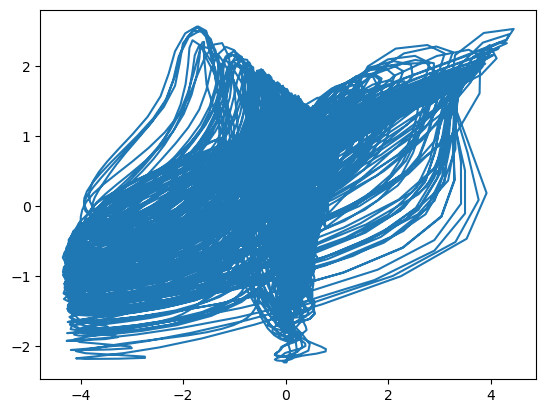

In [508]:
plt.plot(unmixed[:10000,0,1], X[:10000,2])

Text(0.5, 1.0, 'Reconstructed attractor')

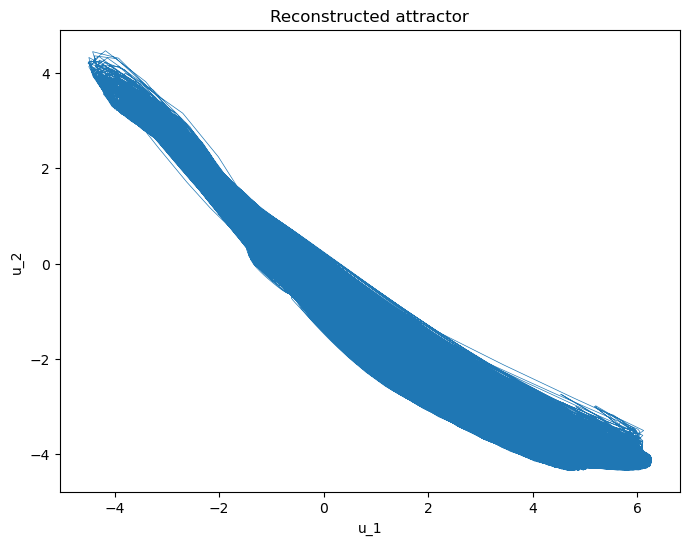

In [509]:
plt.figure(figsize=(8,6),dpi=100)
plt.plot(unmixed[:,0,0],unmixed[:,0,1],lw=0.5)
plt.xlabel("u_1")
plt.ylabel("u_2")
plt.title("Reconstructed attractor")

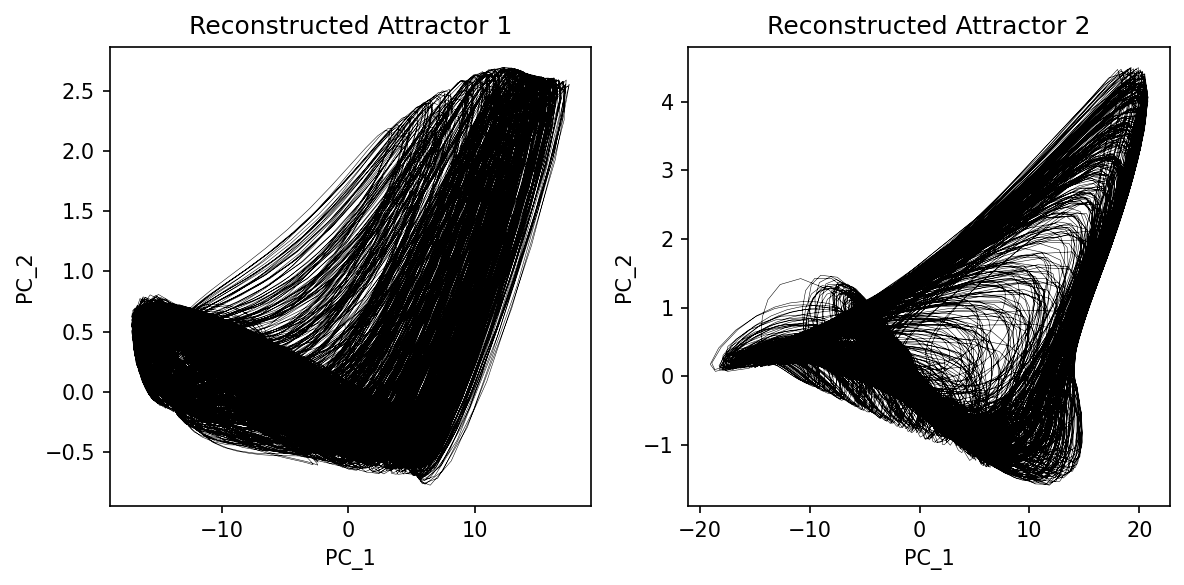

In [510]:
# Assuming 'unmixed' is your data array with shape (n_samples, n_systems, 2)
plt.figure(figsize=(4 * unmixed.shape[1], 4),dpi=150)

for i in range(unmixed.shape[1]):
    plt.subplot(1, unmixed.shape[1], i + 1)
    x_pca = PCA(2).fit_transform(unmixed[:,i,:])
    plt.plot(x_pca[:,0],x_pca[:,1],linewidth=0.25,color="black")
    plt.title(f"Reconstructed Attractor {i + 1}")
    plt.xlabel('PC_1')
    plt.ylabel('PC_2')

plt.tight_layout()
plt.show()

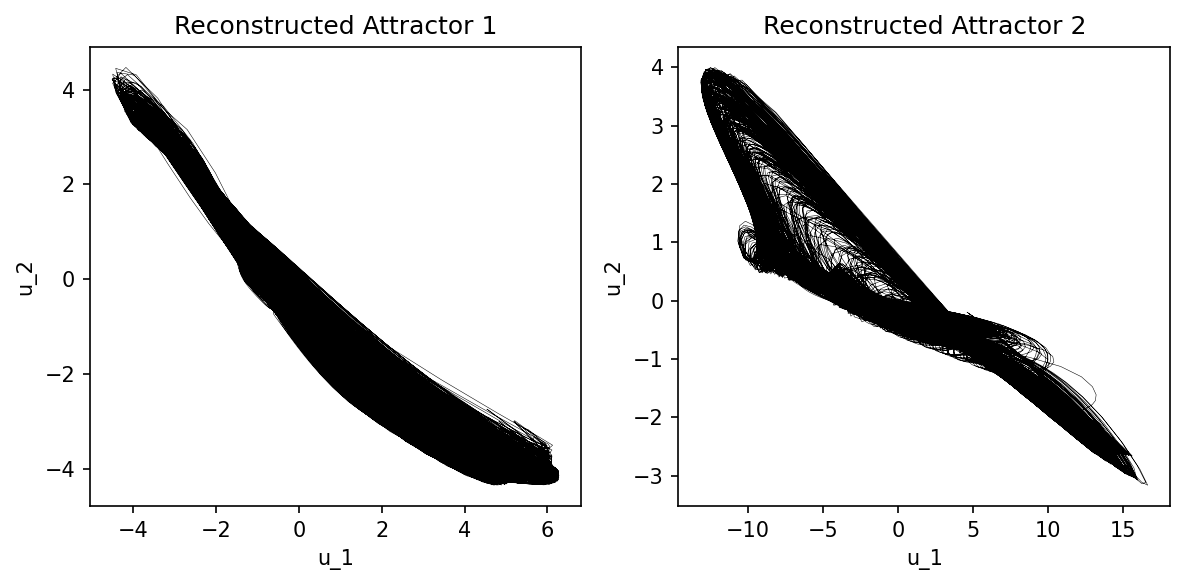

In [511]:
# Assuming 'unmixed' is your data array with shape (n_samples, n_systems, 2)
plt.figure(figsize=(4 * unmixed.shape[1], 4),dpi=150)

for i in range(unmixed.shape[1]):
    plt.subplot(1, unmixed.shape[1], i + 1)
    plt.plot(unmixed[:, i, 0], unmixed[:, i, 1], linewidth=0.25,color="black")
    plt.title(f"Reconstructed Attractor {i + 1}")
    plt.xlabel('u_1')
    plt.ylabel('u_2')

plt.tight_layout()
plt.show()

Text(0, 0.5, 'Learned projections')

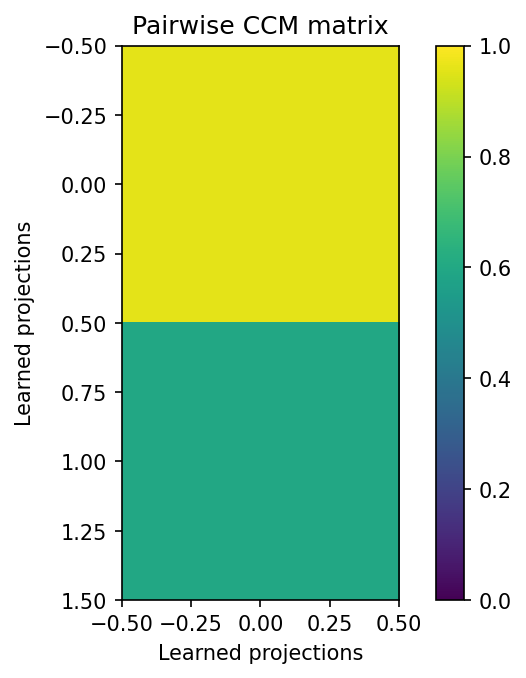

In [512]:
ccm_matrix_unmixed = CCM.PairwiseCCM().compute(
    X[None],
    np.transpose(unmixed, axes=(1, 0, 2)),
    1500, 400, 60, 20,
    method="simplex",
).mean(axis=0)
plt.figure(dpi=150)
plt.imshow(ccm_matrix_unmixed, vmin=0, vmax=1)
plt.colorbar()
plt.title("Pairwise CCM matrix")
plt.xlabel("Learned projections")
plt.ylabel("Learned projections")


Text(0, 0.5, 'Learned projections')

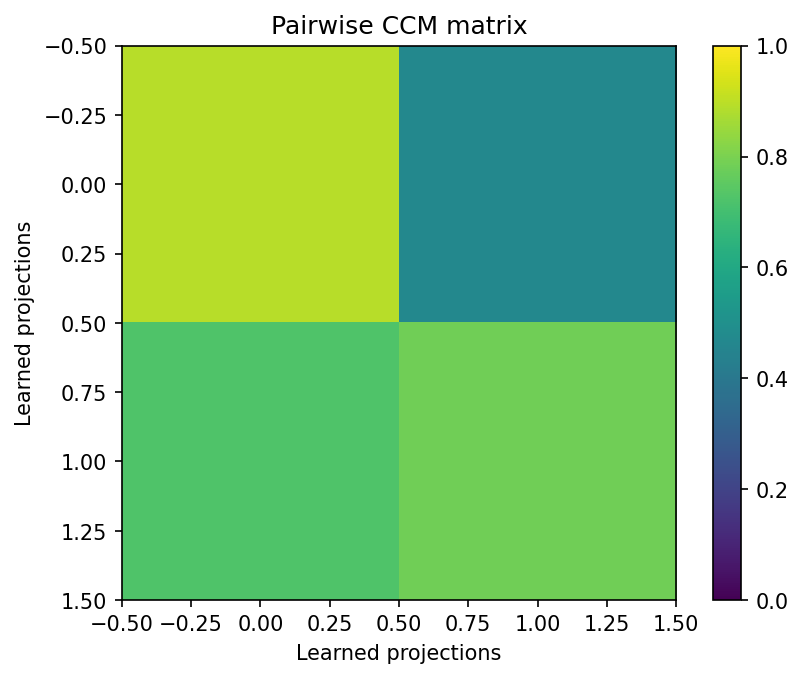

In [513]:
ccm_matrix_unmixed = CCM.PairwiseCCM().compute(
    np.transpose(unmixed, axes=(1, 0, 2)),
    np.transpose(unmixed, axes=(1, 0, 2)),
    1500, 400, 60, 20,
    method="simplex",
    nbrs_num=15,
).mean(axis=0)
plt.figure(dpi=150)
plt.imshow(ccm_matrix_unmixed, vmin=0, vmax=1)
plt.colorbar()
plt.title("Pairwise CCM matrix")
plt.xlabel("Learned projections")
plt.ylabel("Learned projections")


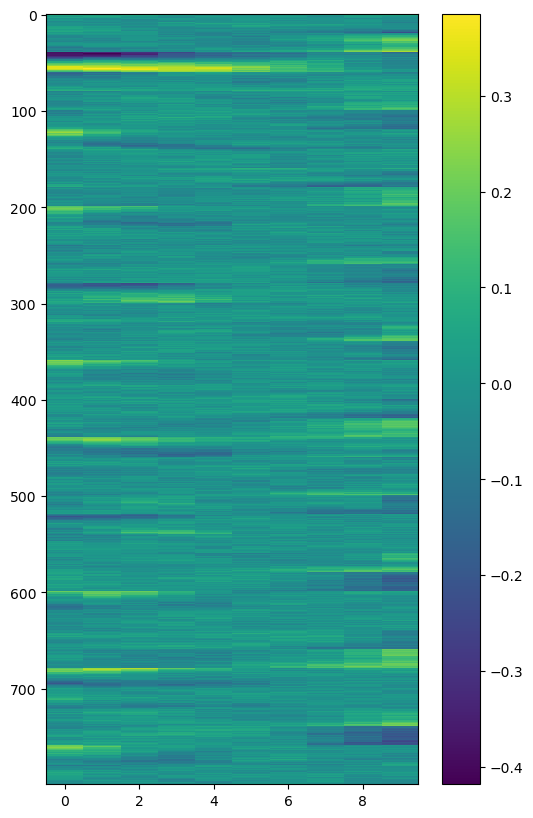

In [514]:

plt.figure(figsize=(6,10))
plt.imshow((trainer.model.get_weights()[:,0]),aspect="auto",interpolation="nearest")
plt.colorbar()

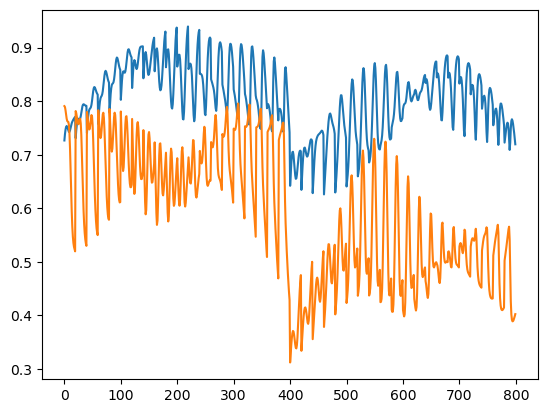

In [515]:
ccm_matrix_unmixed = CCM.PairwiseCCM().compute(
    np.transpose(unmixed, axes=(1, 0, 2)),
    observables.T[:,:,None],
    1500, 400, 60, 20,
    method="simplex",
).mean(axis=0)
plt.plot(ccm_matrix_unmixed)

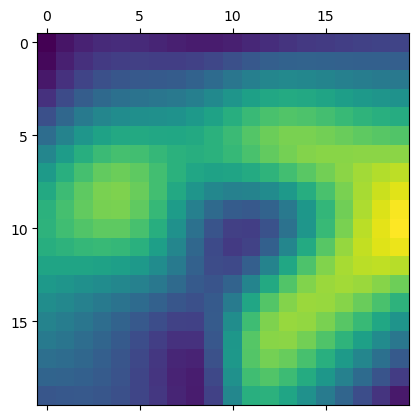

In [516]:
plt.matshow(ccm_matrix_unmixed[:400,0].reshape(20,20))